# Twitter Sentiment Analysis

In [5]:
!pip install --upgrade pip 
!pip install gensim[extra]
!pip install --upgrade keras
!pip install --upgrade pandas 
!pip install --upgrade tensorflow

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [6]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import tensorflow
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [8]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [9]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [10]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [11]:
df.head(5)

ImportError: cannot import name 'is_url'

   target                        ...                                                                       text
0       0                        ...                          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0                        ...                          is upset that he can't update his Facebook by ...
2       0                        ...                          @Kenichan I dived many times for the ball. Man...
3       0                        ...                            my whole body feels itchy and like its on fire 
4       0                        ...                          @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [13]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 565 ms, sys: 37.8 ms, total: 603 ms
Wall time: 602 ms


Text(0.5,1,'Dataset labels distribuition')

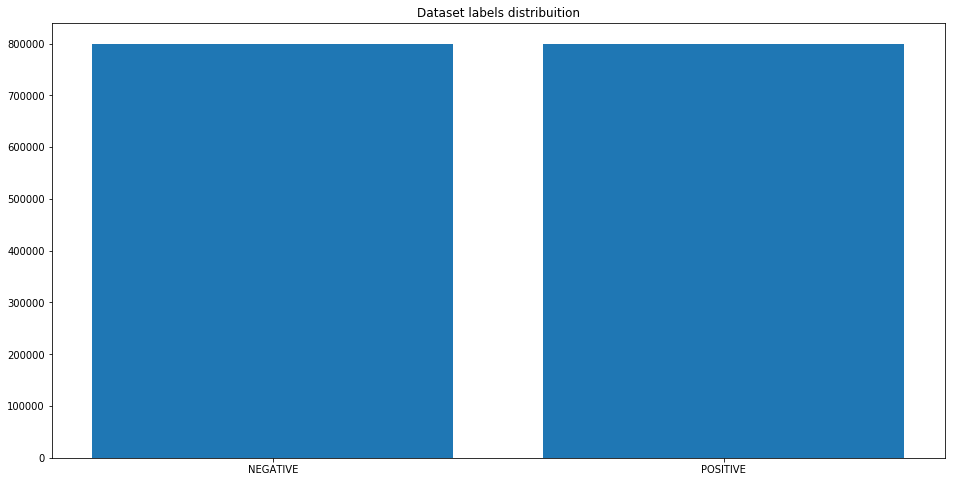

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 51.4 s, sys: 195 ms, total: 51.6 s
Wall time: 51.6 s


### Split train and test

In [18]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [19]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.92 s, sys: 432 ms, total: 3.35 s
Wall time: 3.35 s


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [21]:
w2v_model.build_vocab(documents)

2023-10-20 12:28:28,678 : INFO : collecting all words and their counts
2023-10-20 12:28:28,679 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-10-20 12:28:28,697 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2023-10-20 12:28:28,714 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2023-10-20 12:28:28,732 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2023-10-20 12:28:28,752 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2023-10-20 12:28:28,772 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2023-10-20 12:28:28,791 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2023-10-20 12:28:28,811 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2023-10-20 12:28:28,830 : INFO : PROGRESS: at s

In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [23]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-10-20 12:28:32,028 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2023-10-20 12:28:33,069 : INFO : EPOCH 1 - PROGRESS: at 7.60% examples, 610792 words/s, in_qsize 15, out_qsize 0
2023-10-20 12:28:34,083 : INFO : EPOCH 1 - PROGRESS: at 16.81% examples, 678619 words/s, in_qsize 14, out_qsize 1
2023-10-20 12:28:35,085 : INFO : EPOCH 1 - PROGRESS: at 25.15% examples, 680763 words/s, in_qsize 14, out_qsize 1
2023-10-20 12:28:36,086 : INFO : EPOCH 1 - PROGRESS: at 34.02% examples, 692964 words/s, in_qsize 15, out_qsize 0
2023-10-20 12:28:37,099 : INFO : EPOCH 1 - PROGRESS: at 43.10% examples, 702096 words/s, in_qsize 15, out_qsize 0
2023-10-20 12:28:38,107 : INFO : EPOCH 1 - PROGRESS: at 49.59% examples, 673519 words/s, in_qsize 14, out_qsize 1
2023-10-20 12:28:39,151 : INFO : EPOCH 1 - PROGRESS: at 57.71% examples, 668615 words/s, in_qsize 16, out_qsize 0
2023-10-20 12:28:40,152 : INFO : EPOCH 1 - PROGRESS: 

CPU times: user 21min 10s, sys: 6.54 s, total: 21min 16s
Wall time: 6min 12s


(263124196, 295270528)

In [24]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2023-10-20 12:34:44,973 : INFO : precomputing L2-norms of word weight vectors
/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5647304058074951),
 ('loves', 0.5582870244979858),
 ('adore', 0.5449224710464478),
 ('loved', 0.5384830236434937),
 ('amazing', 0.5127148628234863),
 ('looove', 0.488789826631546),
 ('awesome', 0.46602287888526917),
 ('miss', 0.4449414610862732),
 ('loveee', 0.4404863715171814),
 ('loove', 0.43822669982910156)]

### Tokenize Text

In [25]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 19.5 s, sys: 359 ms, total: 19.9 s
Wall time: 19.5 s


In [26]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 27.5 s, sys: 1.25 s, total: 28.8 s
Wall time: 28.8 s


### Label Encoder 

In [27]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [28]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [29]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [30]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [31]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [32]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [33]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [35]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [36]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 586s 509us/step - loss: 0.5039 - acc: 0.7504 - val_loss: 0.4664 - val_acc: 0.7782
Epoch 2/8
1152000/1152000 [==============================] - 584s 507us/step - loss: 0.4793 - acc: 0.7673 - val_loss: 0.4585 - val_acc: 0.7833
Epoch 3/8
1152000/1152000 [==============================] - 587s 510us/step - loss: 0.4733 - acc: 0.7712 - val_loss: 0.4571 - val_acc: 0.7851
Epoch 4/8
1152000/1152000 [==============================] - 594s 516us/step - loss: 0.4705 - acc: 0.7733 - val_loss: 0.4533 - val_acc: 0.7863
Epoch 5/8
1152000/1152000 [==============================] - 584s 507us/step - loss: 0.4676 - acc: 0.7745 - val_loss: 0.4528 - val_acc: 0.7871
Epoch 6/8
1152000/1152000 [==============================] - 588s 511us/step - loss: 0.4659 - acc: 0.7759 - val_loss: 0.4502 - val_acc: 0.7884
Epoch 7/8
1152000/1152000 [==============================] - 590s 513us/step - loss: 0.46

### Evaluate

In [37]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 56s 175us/step

ACCURACY: 0.789890625
LOSS: 0.4470647978305817
CPU times: user 1min 30s, sys: 10.8 s, total: 1min 41s
Wall time: 56.1 s


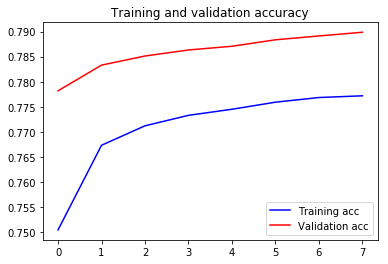

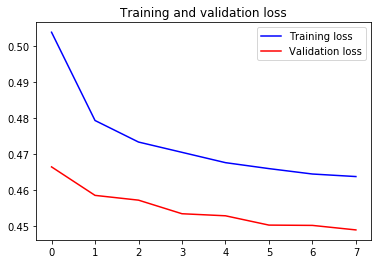

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [39]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [40]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [41]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.971908450126648,
 'elapsed_time': 0.3359944820404053}

In [42]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.012704471126198769,
 'elapsed_time': 0.16874909400939941}

In [43]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.3325764238834381,
 'elapsed_time': 0.16769981384277344}

### Confusion Matrix

In [44]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 20s 63us/step
CPU times: user 14 s, sys: 1.7 s, total: 15.7 s
Wall time: 20.5 s


In [45]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

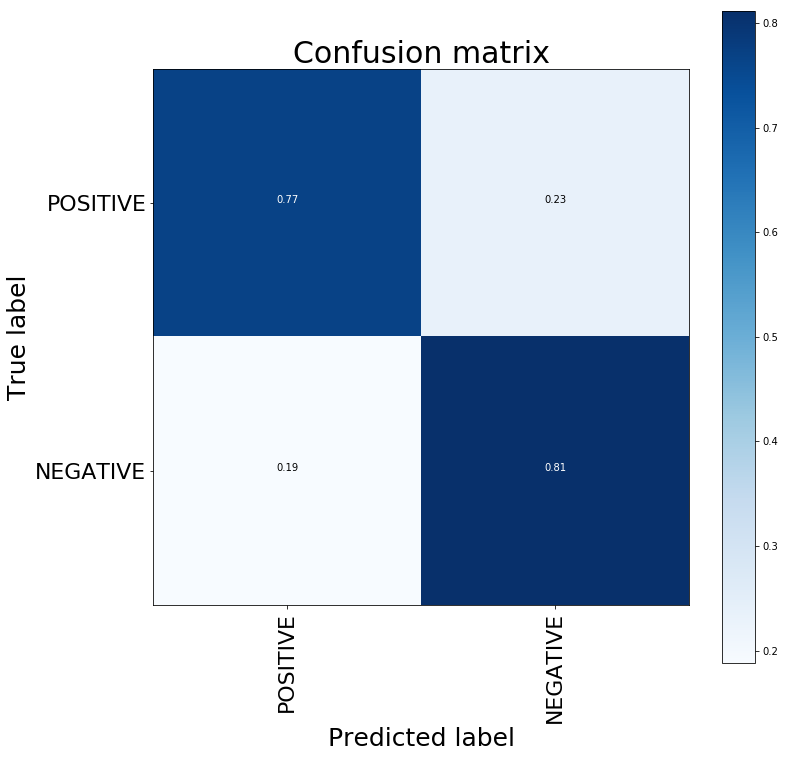

CPU times: user 1.24 s, sys: 359 ms, total: 1.6 s
Wall time: 1.13 s


In [46]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [47]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.78    159494
    POSITIVE       0.78      0.81      0.79    160506

   micro avg       0.79      0.79      0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [48]:
accuracy_score(y_test_1d, y_pred_1d)

0.789890625

### Save model

In [49]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2023-10-20 13:55:21,437 : INFO : saving Word2Vec object under model.w2v, separately None
2023-10-20 13:55:21,438 : INFO : not storing attribute vectors_norm
2023-10-20 13:55:21,440 : INFO : not storing attribute cum_table
2023-10-20 13:55:22,436 : INFO : saved model.w2v
